In [68]:
import pandas as pd
import numpy as np

state_selector = ['08', '20', '31', '40', '46', '48'] 

Read yield data

In [63]:
us_yield = pd.read_csv("../data/CY-Bench/US/wheat/yield_wheat_US.csv")
us_yield = us_yield.assign(state=us_yield["adm_id"].apply(lambda x: x.split("-")[1]))
us_yield = us_yield.loc[(us_yield["state"].isin(state_selector)) & (us_yield["harvest_year"].between(2004, 2023))].reset_index(drop=True)

In [91]:
predictors = pd.read_csv("../data/preprocessed/US/cy_bench_16daybins_wheat_US_v2.csv")
predictors = predictors.assign(state=predictors["adm_id"].apply(lambda x: x.split("-")[1]))

In [93]:
predictors.state.unique()

array(['01', '04', '05', '06', '08', '10', '12', '13', '16', '17', '18',
       '19', '20', '21', '22', '24', '26', '27', '28', '29', '30', '31',
       '32', '34', '35', '36', '37', '38', '39', '40', '41', '42', '45',
       '46', '47', '48', '49', '51', '53', '54', '55', '56'], dtype=object)

Trend is estimated using the training period.
- at least 10 observations in 14 year training period from 2004-2017.


All adm_ids that fullfil that criteria are used to filter the entire period 2004-2017.

In [64]:
print("previous shape: ", us_yield.loc[us_yield["harvest_year"].between(2004, 2017)].shape, 
      us_yield.loc[us_yield["harvest_year"].between(2018, 2020)].shape,
      us_yield.loc[us_yield["harvest_year"].between(2021, 2023)].shape)

relevant_ids = us_yield.loc[us_yield["harvest_year"].between(2004, 2017)].groupby("adm_id").size().loc[lambda x: x >= 10].index
us_yield_filtered = us_yield.loc[us_yield["adm_id"].isin(relevant_ids)].reset_index(drop=True)

print("new shape: ", us_yield_filtered.loc[us_yield_filtered["harvest_year"].between(2004, 2017)].shape, 
      us_yield_filtered.loc[us_yield_filtered["harvest_year"].between(2018, 2020)].shape,
      us_yield_filtered.loc[us_yield_filtered["harvest_year"].between(2021, 2023)].shape)

previous shape:  (1317, 8) (224, 8) (244, 8)
new shape:  (1300, 8) (222, 8) (238, 8)


In [67]:
adm_id_to_polyfit = dict.fromkeys(relevant_ids)
intercepts = []
slopes = []
for id in relevant_ids:
    y = us_yield_filtered.loc[(us_yield_filtered["adm_id"] == id) & (us_yield_filtered["harvest_year"].between(2004, 2017)), "yield"] 
    x = us_yield_filtered.loc[(us_yield_filtered["adm_id"] == id) & (us_yield_filtered["harvest_year"].between(2004, 2017)), "harvest_year"]
    slope, bias = np.polyfit(x, y, 1)
    slopes.append(slope)
    intercepts.append(bias)
    adm_id_to_polyfit[id] = (slope, bias)
    
us_yield_filtered["yield_trend"] = us_yield_filtered[["adm_id", "harvest_year"]].apply(lambda x: adm_id_to_polyfit[x[0]][0] * x[1] + adm_id_to_polyfit[x[0]][1], axis=1)
us_yield_filtered["yield_anomaly"] = (us_yield_filtered["yield"] - us_yield_filtered["yield_trend"]) / us_yield_filtered["yield_trend"]

In [78]:
# Calculate state yield as weighted average from counties
us_yield_filtered["weighted_yield"] = us_yield_filtered.apply(lambda x: x["yield"] * x["harvest_area"], axis=1)
yield_by_state = us_yield_filtered.groupby(["state", "harvest_year"]).apply(lambda x: x["weighted_yield"].sum() / x["harvest_area"].sum()).reset_index(name="yield")
us_yield_filtered = us_yield_filtered.drop(columns=["weighted_yield"])

Kansas state intercept:  -50.53 Kansas state slope:  0.03


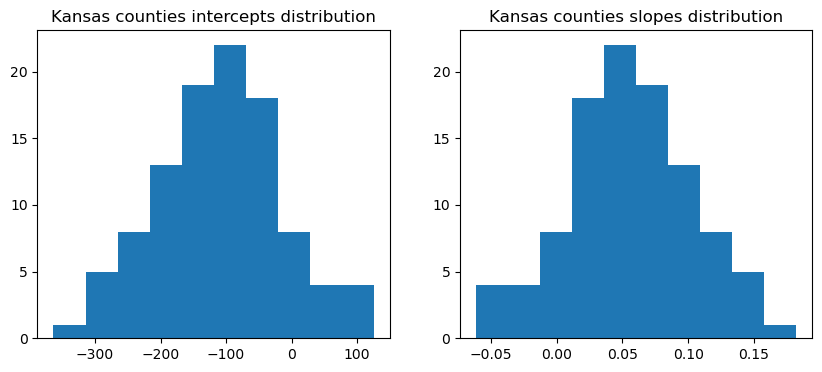

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.ravel()

axs[0].hist(intercepts, bins=10);
axs[0].set_title("Kansas counties intercepts distribution")
axs[1].hist(slopes, bins=10);
axs[1].set_title("Kansas counties slopes distribution")

state_slope, state_bias = np.polyfit(yield_by_state["harvest_year"], yield_by_state["yield"], 1)
print("Kansas state intercept: ", np.round(state_bias, 2), "Kansas state slope: ", np.round(state_slope, 2))

In [59]:
us_yield_filtered.sample(5)

,crop_name,country_code,adm_id,harvest_year,yield,harvest_area,production,state,yield_trend,yield_anomaly
4130,winter_wheat,US,US-40-047,2016,2.63143,97937.40,257176.00,40,2.299240,0.144478
1302,winter_wheat,US,US-40-081,2007,1.00950,404.70,408.00,40,1.975846,-0.489080
2727,winter_wheat,US,US-20-201,2023,2.64489,10077.03,26628.80,20,2.133096,0.239930
5033,winter_wheat,US,US-48-483,2015,1.58828,3156.66,5010.24,48,1.372698,0.157050
836,winter_wheat,US,US-31-019,2005,2.76603,3399.48,9389.44,31,2.850525,-0.029642


In [61]:
us_yield_filtered.to_csv("../data/preprocessed/US/yield_wheat_US_filtered.csv", index=False)

<Axes: ylabel='Frequency'>

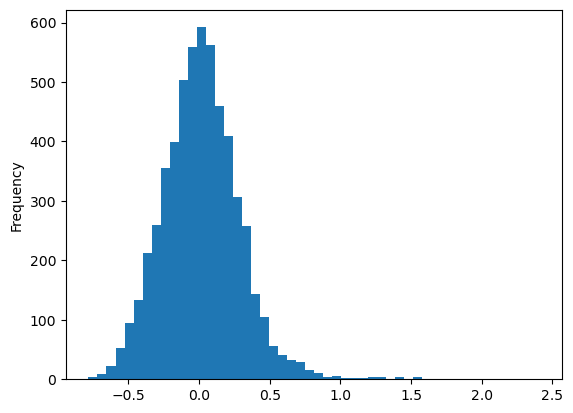

In [60]:
us_yield_filtered["yield_anomaly"].plot(kind="hist", bins=50)